In [47]:
#Import packages
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
import s3fs
import geocat.comp
from datetime import datetime
import dask
import zarr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import netCDF4
import os
import proplot as pplt
import warnings
from numpy import meshgrid, deg2rad, gradient, cos, sin
from xarray import DataArray
from scipy import stats
warnings.filterwarnings('ignore')

In [75]:
#ERA5 PRECIPITATION INDEX SCRIPT
files='/home/jupyter-dipti/work/ISMR_CITCZ/Data/Regrided_ERA5.nc'
#Open ERA5 Dataset
data=xr.open_dataset(files)
cres=data.cres
cresSurf=data.cresSurf
netTOA=data.netTOA
crel=data.crel
crelSurf=data.crelSurf
pr=data.pr
land=data.lsMask

lat=cres.lat
lon=cres.lon

time=cres.time
land=land.sel(lon=slice(60,100),lat=slice(10,30))

#Select Monsoon Months
months=[6,7,8,9]
lagmonths=[2,3,4,5]
#months=[7]
#lagmonths=[5]
#varOut.where(varOut.time.dt.month.isin(months), drop=True) #Change varOut to desired variable
prec=pr.where(pr.time.dt.month.isin(months), drop=True)
land=land.where(land.time.dt.month.isin(months), drop=True)
cres=cres.where(cres.time.dt.month.isin(lagmonths), drop=True)

month_length=prec.time.dt.days_in_month
weights = (
    month_length.groupby("time.month") / month_length.groupby("time.month").sum()
)
# Calculate the weighted average
prec = (prec * weights).groupby("time.month").sum(dim="time")


plottime=prec.time

#Select only the SAM lat,lon range: 60-100E, 10-30N
precip=prec.sel(lon=slice(60,100),lat=slice(10,30))
precip=xr.where(land==0,np.nan,precip) #remove oceans, monsoon is defined as only over land 

#Do weighted correction on precipitation
weights=np.cos(np.deg2rad(precip.lat))
prec_index=precip.weighted(weights).mean(dim=('lat','lon'))
prec_index=prec_index*60*60*24 #conversion to mm/day, exluding dividing by rho and multiplying by 1000mm/m

test=prec_index.rolling(time=4,center=True).mean()


fig,axes=pplt.subplots(figsize=(5,4))
axes.plot(plottime,test)
axes.format(suptitle='ERA5 South Asia July Precipitation')
axes.format(ylabel='Precipitation (mm/day)')
#fig.save('ERA5_SAMonsoon_July_Precseries')

AttributeError: 'DataArray' object has no attribute 'time'

In [2]:
#Specify model names
modelNames=['CESM2','CESM2-FV2','CESM2-WACCM','CESM2-WACCM-FV2','CMCC-CM2-SR5','CanESM5',
'E3SM-1-1','E3SM-1-1-ECA','FGOALS-g3','GFDL-CM4','GFDL-ESM4','GISS-E2-1-H','SAM0-UNICON'] #'MIROC-ES2L' file missing, 'MPI-ESM1-2-HR'has bad data??

othermodels=['MIROC6','MPI-ESM-1-2-HAM','MRI-ESM2-0']

In [ ]:
#CMIP6 Precipitation Index Script
#Do now for models
download_path='/home/jupyter-dipti/work/data/data/'
inputstr='.historical.r1i1p1f1.Input.netSurfcs.nc'
outputstr='.historical.r1i1p1f1.Output.nc'

fig,axes = pplt.subplots([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
for i,name in enumerate(modelNames):
    #get input variables in xarray
    files=download_path+name+inputstr
    data=xr.open_dataset(files)        
    lons=data['lon']
    lats=data['lat']
    land=data['lsMask']
    cres=data['cres']
    
    cres=cres[1548:,:,:]
    datetimeindex=cres.indexes['time'].to_datetimeindex()
    cres['time']=datetimeindex
    
    #Done getting input variables, now get output variables - precipition
    files1=download_path+name+outputstr
    data1=xr.open_dataset(files1)
    prec=data1['pr']
    land=data1['lsMask']
    precip=xr.where(land==0,np.nan,prec) #remove oceans, monsoon is defined as only over land 
    precip=precip[1548:,:,:]
    precip['time']=datetimeindex
    
    
    def detrend(x:np.ndarray,time:np.ndarray):
        nt,nx,ny = x.shape
        xtemp = x.reshape(nt,nx*ny)
        p = np.polyfit(time, xtemp, deg=3)
        fit = p[0]*(time[:,np.newaxis] **3)+ p[1]*(time[:,np.newaxis]**2) + p[2]*(time[:,np.newaxis]) + p[3]
        return x - fit.reshape(nt,nx,ny)
   

    #Do the weighted area correction:
    def earth_radius(lat):
        from numpy import deg2rad, sin, cos

        # define oblate spheroid from WGS84
        a = 6378137
        b = 6356752.3142
        e2 = 1 - (b**2/a**2)
    
    # convert from geodecic to geocentric
    # see equation 3-110 in WGS84
        lat = deg2rad(lat)
        lat_gc = np.arctan( (1-e2)*np.tan(lat) )
    
    # radius equation
    # see equation 3-107 in WGS84
        r = (
            (a * (1 - e2)**0.5) 
            / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
            )
    
        return r

    def area_grid(lat, lon):
    
        from numpy import meshgrid, deg2rad, gradient, cos
        from xarray import DataArray

        xlon, ylat = meshgrid(lon, lat)
        R = earth_radius(ylat)
    
    
        dlat = deg2rad(gradient(ylat, axis=0))
        dlon = deg2rad(gradient(xlon, axis=1))
    
        dy = dlat * R
        dx = dlon * R * cos(deg2rad(ylat))
    
        area = dy * dx
    
        xda = DataArray(
            area,
            dims=["lat", "lon"],
            coords={"lat": lat, "lon": lon},
            attrs={
                "long_name": "area_per_pixel",
            "description": "area per pixel",
            "units": "m^2",
            },
        )
        return xda
    
    
    da_area = area_grid(data['lat'], data['lon'])
    total_area=da_area.sum(['lat','lon'])

    
    #Select July index
    month_idxs=cres.groupby('time.month').groups
    july_idxs=month_idxs[7]
    test_idxs=month_idxs[7]
    cres_july=cres.isel(time=july_idxs)
    prec_july=precip.isel(time=july_idxs)
    
    testtime=prec_july.time

    SAMlat=cres_july.lat
    SAMlon=cres_july.lon

    #Detrend data sets
    time=cres_july.time
    cres_july=cres_july.to_numpy()
    time=time.to_numpy()
    prec_july=prec_july.to_numpy()

    time=time.astype(int)/10**9

    cres_july=detrend(cres_july,time)
    cres_july=xr.DataArray(cres_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_july=detrend(prec_july,time)
    prec_july=xr.DataArray(prec_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_july=xr.where(prec_july<0,0,prec_july) #apply Non-negative precipitation physical constraint

    #Select only the SAM lat,lon range: 60-100E, 10-30N 
    prec_july=prec_july.sel(lon=slice(60,100))
    prec_july=prec_july.sel(lat=slice(10,30))

    
    #Do weighted correction on precipitation
    prec_weighted=(prec_july*da_area)/total_area #Do the weighted area correction
    prec_weighted_mean=prec_weighted.sum(['lat','lon']) #Sum across lat lon to get the mean weighted value
    prec_index=prec_weighted_mean*60*60*24 #conversion to mm/yr, exluding dividing by rho and multiplying by 1000mm/m 

    con=axes[i].plot(testtime,prec_index)
    axes[i].set_title(name)
axes.format(suptitle='CMIP6 Model South Asia July Precipitation')
fig.save('SAMonsoon_July_Precseries')

In [ ]:
#CMIP6 models with different time format precipitation index plot
#Do now for other models
download_path='/home/jupyter-dipti/work/data/data/'
inputstr='.historical.r1i1p1f1.Input.netSurfcs.nc'
outputstr='.historical.r1i1p1f1.Output.nc'

fig,axes = pplt.subplots([[1,2,3,4]])
for i,name in enumerate(othermodels):
    #get input variables in xarray
    files=download_path+name+inputstr
    data=xr.open_dataset(files)        
    lons=data['lon']
    lats=data['lat']
    cres=data['cres']
    
    cres=cres[1548:,:,:]
    cres['time']=datetimeindex
    
    #Done getting input variables, now get output variables - precipition
    files1=download_path+name+outputstr
    data1=xr.open_dataset(files1)
    prec=data1['pr']
    land=data1['lsMask']
    precip=xr.where(land==0,np.nan,prec) #remove oceans, monsoon is defined as only over land 
    precip=precip[1548:,:,:]
    precip['time']=datetimeindex
    
    
    def detrend(x:np.ndarray,time:np.ndarray):
        nt,nx,ny = x.shape
        xtemp = x.reshape(nt,nx*ny)
        p = np.polyfit(time, xtemp, deg=3)
        fit = p[0]*(time[:,np.newaxis] **3)+ p[1]*(time[:,np.newaxis]**2) + p[2]*(time[:,np.newaxis]) + p[3]
        return x - fit.reshape(nt,nx,ny)
   

    #Do the weighted area correction:
    def earth_radius(lat):
        from numpy import deg2rad, sin, cos

        # define oblate spheroid from WGS84
        a = 6378137
        b = 6356752.3142
        e2 = 1 - (b**2/a**2)
    
    # convert from geodecic to geocentric
    # see equation 3-110 in WGS84
        lat = deg2rad(lat)
        lat_gc = np.arctan( (1-e2)*np.tan(lat) )
    
    # radius equation
    # see equation 3-107 in WGS84
        r = (
            (a * (1 - e2)**0.5) 
            / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
            )
    
        return r

    def area_grid(lat, lon):
    
        from numpy import meshgrid, deg2rad, gradient, cos
        from xarray import DataArray

        xlon, ylat = meshgrid(lon, lat)
        R = earth_radius(ylat)
    
    
        dlat = deg2rad(gradient(ylat, axis=0))
        dlon = deg2rad(gradient(xlon, axis=1))
    
        dy = dlat * R
        dx = dlon * R * cos(deg2rad(ylat))
    
        area = dy * dx
    
        xda = DataArray(
            area,
            dims=["lat", "lon"],
            coords={"lat": lat, "lon": lon},
            attrs={
                "long_name": "area_per_pixel",
            "description": "area per pixel",
            "units": "m^2",
            },
        )
        return xda
    
    
    da_area = area_grid(data['lat'], data['lon'])
    total_area=da_area.sum(['lat','lon'])

    
    #Select July index
    month_idxs=cres.groupby('time.month').groups
    july_idxs=month_idxs[7]
    test_idxs=month_idxs[7]
    cres_july=cres.isel(time=july_idxs)
    prec_july=precip.isel(time=july_idxs)
    
    testtime=prec_july.time

    SAMlat=cres_july.lat
    SAMlon=cres_july.lon

    #Detrend data sets
    time=cres_july.time
    cres_july=cres_july.to_numpy()
    time=time.to_numpy()
    prec_july=prec_july.to_numpy()

    time=time.astype(int)/10**9

    cres_july=detrend(cres_july,time)
    cres_july=xr.DataArray(cres_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_july=detrend(prec_july,time)
    prec_july=xr.DataArray(prec_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_july=xr.where(prec_july<0,0,prec_july) #apply Non-negative precipitation physical constraint

    #Select only the SAM lat,lon range: 60-100E, 10-30N 
    prec_july=prec_july.sel(lon=slice(60,100))
    prec_july=prec_july.sel(lat=slice(10,30))

    
    #Do weighted correction on precipitation
    prec_weighted=(prec_july*da_area)/total_area #Do the weighted area correction
    prec_weighted_mean=prec_weighted.sum(['lat','lon']) #Sum across lat lon to get the mean weighted value
    prec_index=prec_weighted_mean*60*60*24 #conversion to mm/yr, exluding dividing by rho and multiplying by 1000mm/m 

    con=axes[i].plot(testtime,prec_index)
    axes[i].set_title(name)
fig.save('OTHER_SAMonsoon_July_Precseries')

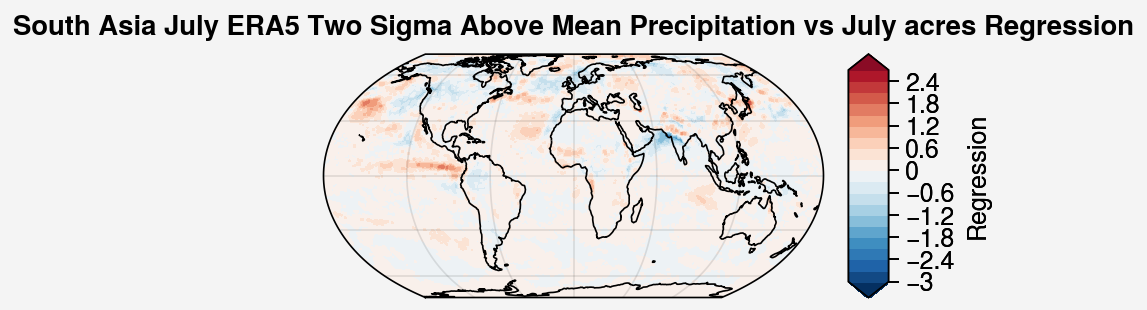

In [3]:
#ERA5 acres regression for July
#Run first the scripts for the ERA5 data
#get input variables in xarray
files='/home/jupyter-dipti/work/ERA5/ERA5_Exp8_Input.nc'
data=xr.open_dataset(files)   
lons=data['lon']
lats=data['lat']
land=data['lsMask']
cres=data['cres']
cresSurf=data['cresSurf']

acres=cres-cresSurf

#Done getting input variables, now get output variables i.e precipition
files1='/home/jupyter-dipti/work/ERA5/ERA5_Exp8_Output.nc'
data1=xr.open_dataset(files1)
prec=data1['pr']

prec=xr.where(land==0,np.nan,prec) #remove oceans, monsoon is defined as only over land 

#Define detrend function to apply to data
def detrend(x:np.ndarray,time:np.ndarray):
        nt,nx,ny = x.shape
        xtemp = x.reshape(nt,nx*ny)
        p = np.polyfit(time, xtemp, deg=3)
        fit = p[0]*(time[:,np.newaxis] **3)+ p[1]*(time[:,np.newaxis]**2) + p[2]*(time[:,np.newaxis]) + p[3]
        return x - fit.reshape(nt,nx,ny)

    #Do the weighted area correction:
def earth_radius(lat):
    from numpy import deg2rad, sin, cos

    # define oblate spheroid from WGS84
    a = 6378137
    b = 6356752.3142
    e2 = 1 - (b**2/a**2)
    
    # convert from geodecic to geocentric
    lat = deg2rad(lat)
    lat_gc = np.arctan( (1-e2)*np.tan(lat) )
    
    # radius equation
    r = (
        (a * (1 - e2)**0.5) 
        / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
        )
    
    return r

def area_grid(lat, lon):
    from numpy import meshgrid, deg2rad, gradient, cos
    from xarray import DataArray

    xlon, ylat = meshgrid(lon, lat)
    R = earth_radius(ylat)
    
    
    dlat = deg2rad(gradient(ylat, axis=0))
    dlon = deg2rad(gradient(xlon, axis=1))
    
    dy = dlat * R
    dx = dlon * R * cos(deg2rad(ylat))
    
    
    area = dy * dx
    
    xda = DataArray(
        area,
        dims=["lat", "lon"],
        coords={"lat": lat, "lon": lon},
        attrs={
            "long_name": "area_per_pixel",
        "description": "area per pixel",
        "units": "m^2",
        },
    )
    return xda

da_area = area_grid(data['lat'], data['lon'])
total_area=da_area.sum(['lat','lon'])

#Align times with CMIP time by only looking at 1979-2014
acres=acres[:432,:,:]
precip=prec[:432,:,:]

#Select July index
month_idxs=acres.groupby('time.month').groups
july_idxs=month_idxs[7]
test_idxs=month_idxs[7]
acres_july=acres.isel(time=test_idxs)
prec_july=precip.isel(time=july_idxs)

SAMlat=acres_july.lat
SAMlon=acres_july.lon

#Detrend data sets
time=acres_july.time
acres_july=acres_july.to_numpy()
time=time.to_numpy()
prec_july=prec_july.to_numpy()

time=time.astype(int)/10**9

acres_july=detrend(acres_july,time)
acres_july=xr.DataArray(acres_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

prec_july=detrend(prec_july,time)
prec_july=xr.DataArray(prec_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

prec_july=xr.where(prec_july<0,0,prec_july) #apply Non-negative precipitation physical constraint

#Select only the SAM lat,lon range: 60-100E, 10-30N for precipitation
prec_july=prec_july.sel(lon=slice(60,100))
prec_july=prec_july[:,240:321,:]

#Do weighted correction on precipitation
prec_weighted=(prec_july*da_area)/total_area #Do the weighted area correction
prec_weighted_mean=prec_weighted.sum(['lat','lon']) #Sum across lat lon to get the mean weighted value
prec_index=prec_weighted_mean*60*60*24 #conversion to mm/yr, exluding dividing by rho and multiplying by 1000mm/m 

mystd=prec_index.std()
twostd=mystd*2
mymean=prec_index.mean()
condition=twostd+mymean

pr_new,acres_july = xr.broadcast(prec_index,acres_july) #broadcast pr_mean array to fill array to allow regression to be executed

#Calculate variable correlations
corr=xr.corr(pr_new,acres_july,dim='time')
fill=xr.zeros_like(corr) #Make array to be filled 
fillarr=fill+1 #Make array full of ones

corr1=xr.where(corr>0.3,fillarr,0) #Threshold value, above set to 1. Else=0 
corr2=xr.where(corr<-0.3,fillarr,0) #Threshold value, below set to 1. Else=0

#define the regression function
def linear_trend(x,y): 
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        pf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(pf[0])

def ints(x,y):
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        ipf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(ipf[1])



#Apply regression function using ufunc to get regression coefficients/slopes
slopes=xr.apply_ufunc(linear_trend,
                    pr_new,acres_july,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['time'],['time']],
                    )


intercepts=xr.apply_ufunc(ints,
                    pr_new,acres_july,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['time'],['time']],
                    )


regression=slopes*condition+intercepts

fig,axes=pplt.subplots([[1]],proj='eqearth')

con=axes.contourf(slopes.lon,slopes.lat,regression,levels=np.arange(-3,3,0.3),extend='both')
#corrs1=axes.contour(lons,lats,corr1,colors='black',linewidths=0.05,levels=2) #Contour 0.3 threshold correlation
#corrs2=axes.contour(lons,lats,corr2,colors='black',linewidths=0.05,levels=2) #Contour 0.3 threshold correlation

fig.format(coast=True)
cbar=plt.colorbar(con)
axes.format(suptitle='South Asia July ERA5 Two Sigma Above Mean Precipitation vs July acres Regression')
cbar.set_label('Regression')
fig.save('ERA5_SAMonsoon_acres_July-July_Regression')

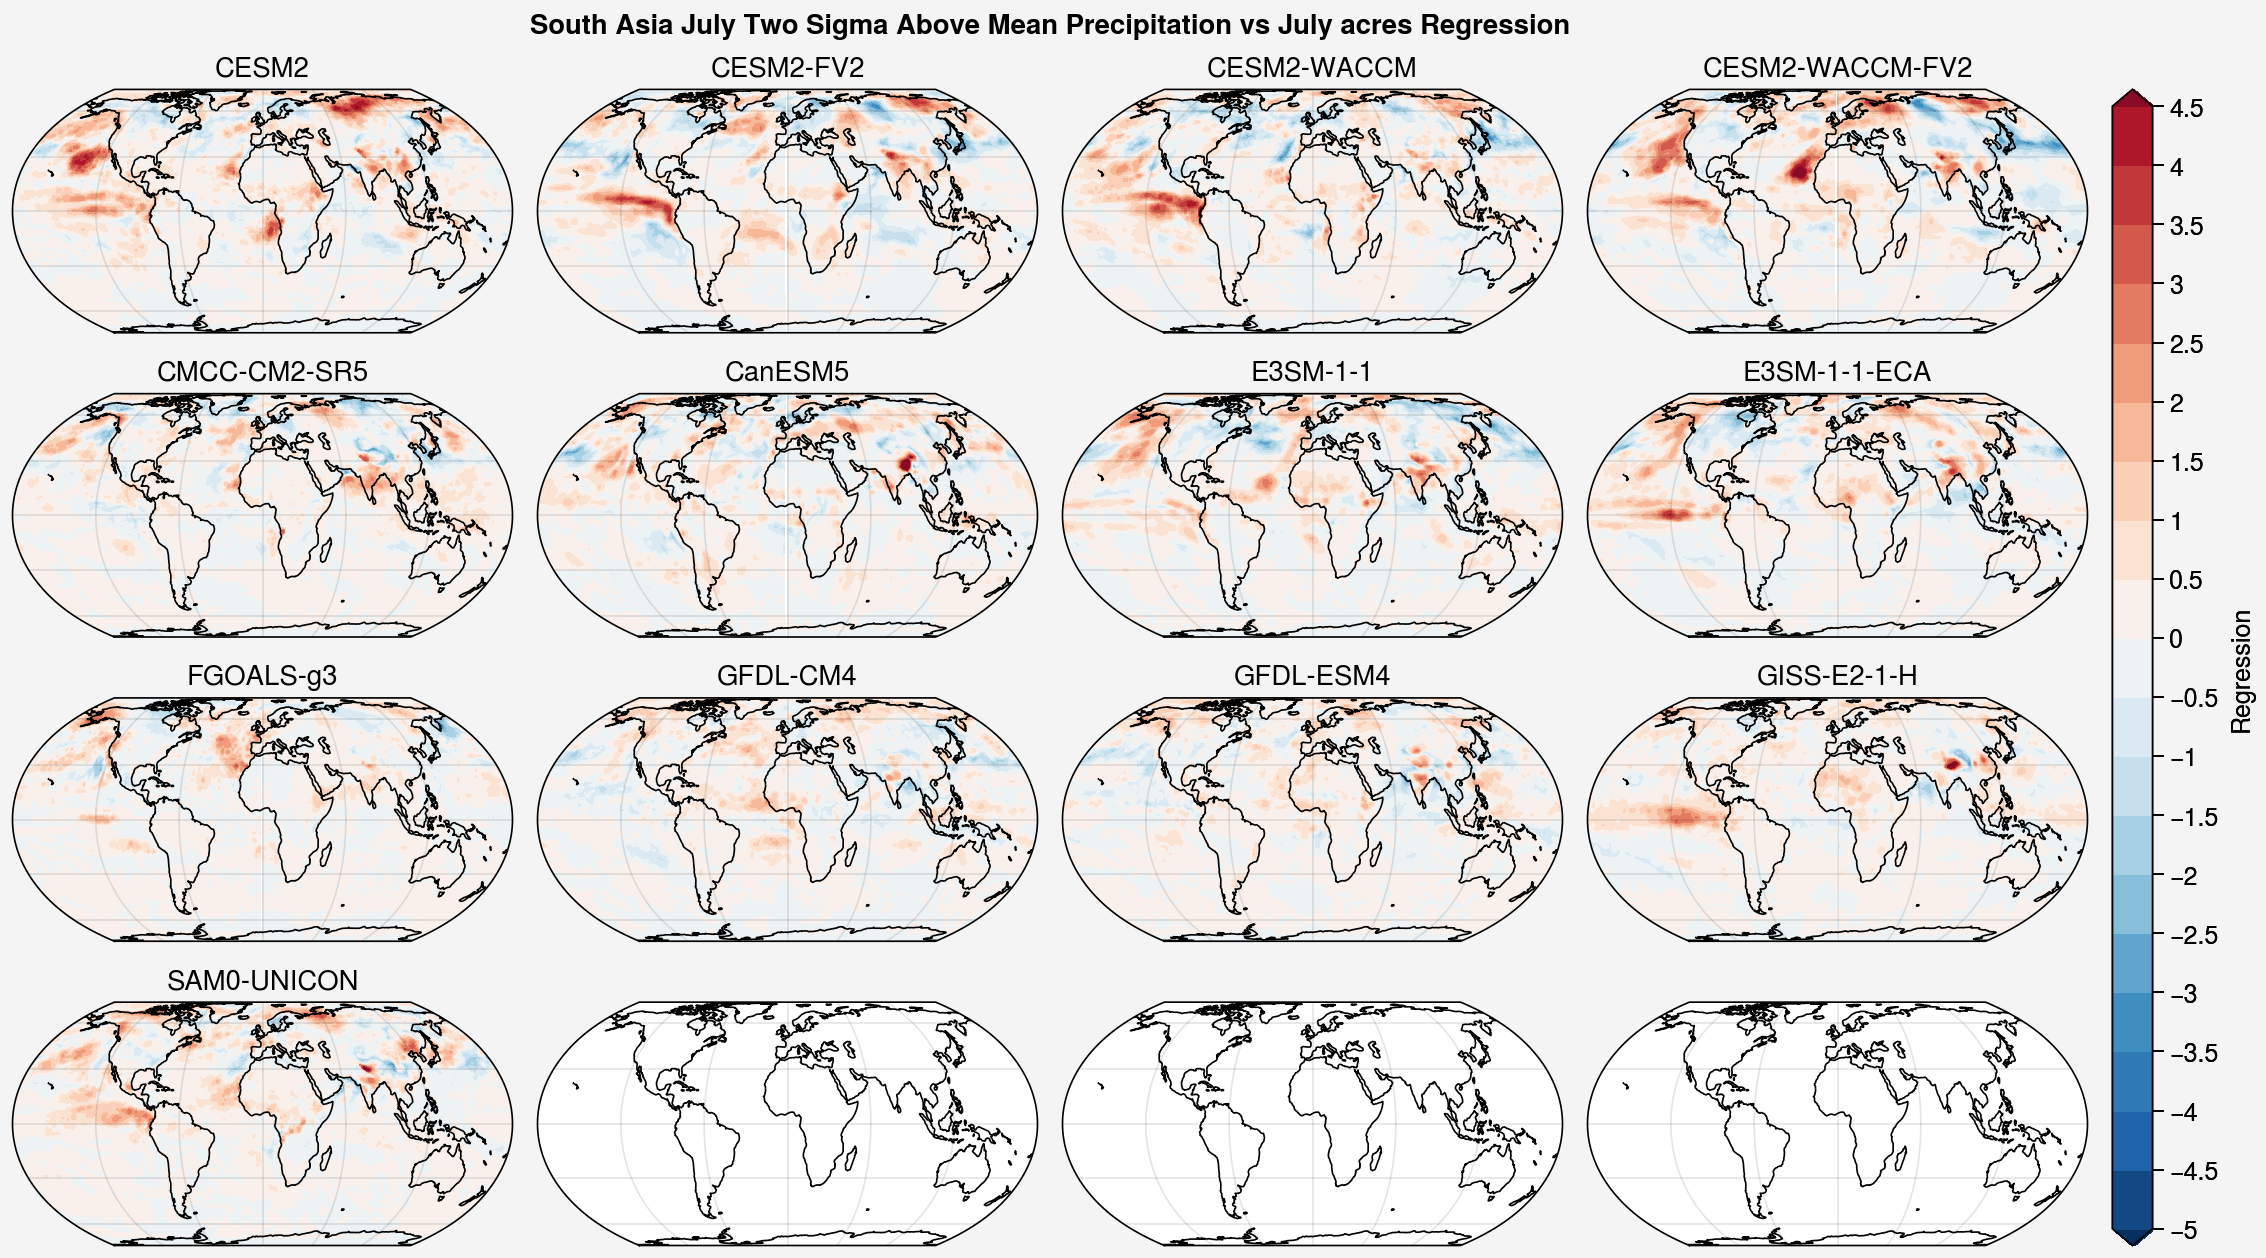

In [4]:
#CMIP6 acres regression for july 
#Do now for models
download_path='/home/jupyter-dipti/work/data/data/'
inputstr='.historical.r1i1p1f1.Input.netSurfcs.nc'
outputstr='.historical.r1i1p1f1.Output.nc'

fig,axes = pplt.subplots([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]],proj='eqearth')
for i,name in enumerate(modelNames):
    #get input variables in xarray
    files=download_path+name+inputstr
    data=xr.open_dataset(files)        
    lons=data['lon']
    lats=data['lat']
    land=data['lsMask']
    cres=data['cres']
    cresSurf=data['cresSurf']

    acres=cres-cresSurf
    
    acres=acres[1548:,:,:]
    datetimeindex=acres.indexes['time'].to_datetimeindex()
    acres['time']=datetimeindex
    
    #Done getting input variables, now get output variables - precipition
    files1=download_path+name+outputstr
    data1=xr.open_dataset(files1)
    prec=data1['pr']
    land=data1['lsMask']
    precip=xr.where(land==0,np.nan,prec) #remove oceans, monsoon is defined as only over land 
    precip=precip[1548:,:,:]
    precip['time']=datetimeindex
    
    
    def detrend(x:np.ndarray,time:np.ndarray):
        nt,nx,ny = x.shape
        xtemp = x.reshape(nt,nx*ny)
        p = np.polyfit(time, xtemp, deg=3)
        fit = p[0]*(time[:,np.newaxis] **3)+ p[1]*(time[:,np.newaxis]**2) + p[2]*(time[:,np.newaxis]) + p[3]
        return x - fit.reshape(nt,nx,ny)
   

    #Do the weighted area correction:
    def earth_radius(lat):
        from numpy import deg2rad, sin, cos

        # define oblate spheroid from WGS84
        a = 6378137
        b = 6356752.3142
        e2 = 1 - (b**2/a**2)
    
    # convert from geodecic to geocentric
    # see equation 3-110 in WGS84
        lat = deg2rad(lat)
        lat_gc = np.arctan( (1-e2)*np.tan(lat) )
    
    # radius equation
    # see equation 3-107 in WGS84
        r = (
            (a * (1 - e2)**0.5) 
            / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
            )
    
        return r

    def area_grid(lat, lon):
    
        from numpy import meshgrid, deg2rad, gradient, cos
        from xarray import DataArray

        xlon, ylat = meshgrid(lon, lat)
        R = earth_radius(ylat)
    
    
        dlat = deg2rad(gradient(ylat, axis=0))
        dlon = deg2rad(gradient(xlon, axis=1))
    
        dy = dlat * R
        dx = dlon * R * cos(deg2rad(ylat))
    
        area = dy * dx
    
        xda = DataArray(
            area,
            dims=["lat", "lon"],
            coords={"lat": lat, "lon": lon},
            attrs={
                "long_name": "area_per_pixel",
            "description": "area per pixel",
            "units": "m^2",
            },
        )
        return xda
    
    
    da_area = area_grid(data['lat'], data['lon'])
    total_area=da_area.sum(['lat','lon'])

    
    #Select July index
    month_idxs=acres.groupby('time.month').groups
    july_idxs=month_idxs[7]
    test_idxs=month_idxs[7]
    acres_july=acres.isel(time=test_idxs)
    prec_july=precip.isel(time=july_idxs)
    
    testtime=prec_july.time

    SAMlat=acres_july.lat
    SAMlon=acres_july.lon

    #Detrend data sets
    time=acres_july.time
    acres_july=acres_july.to_numpy()
    time=time.to_numpy()
    prec_july=prec_july.to_numpy()

    time=time.astype(int)/10**9

    acres_july=detrend(acres_july,time)
    acres_july=xr.DataArray(acres_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_july=detrend(prec_july,time)
    prec_july=xr.DataArray(prec_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_july=xr.where(prec_july<0,0,prec_july) #apply Non-negative precipitation physical constraint

    #Select only the SAM lat,lon range: 60-100E, 10-30N 
    prec_july=prec_july.sel(lon=slice(60,100))
    prec_july=prec_july.sel(lat=slice(10,30))

    #Do weighted correction on precipitation
    prec_weighted=(prec_july*da_area)/total_area #Do the weighted area correction
    prec_weighted_mean=prec_weighted.sum(['lat','lon']) #Sum across lat lon to get the mean weighted value
    prec_index=prec_weighted_mean*60*60*24 #conversion to mm/day, exluding dividing by rho and multiplying by 1000mm/m 

    mystd=prec_index.std()
    twostd=mystd*2
    mymean=prec_index.mean()
    condition=twostd+mymean
    

    pr_new,acres_july = xr.broadcast(prec_index,acres_july) #broadcast pr_mean array to fill array to allow regression to be executed
    
    #Calculate variable correlations
    corr=xr.corr(pr_new,acres_july,dim='time')
    fill=xr.zeros_like(corr) #Make array to be filled 
    fillarr=fill+1 #Make array full of ones

    corr1=xr.where(corr>0.3,fillarr,0) #Threshold value, above set to 1. Else=0 
    corr2=xr.where(corr<-0.3,fillarr,0) #Threshold value, below set to 1. Else=0
    
    #define the regression function
    def linear_trend(x,y): 
        mask=np.isfinite(x)&np.isfinite(y)
        if len(x[mask])==0:
            return np.nan
        else:
            pf=np.polyfit(x[mask],y[mask],1)
            return xr.DataArray(pf[0])

    def ints(x,y):
        mask=np.isfinite(x)&np.isfinite(y)
        if len(x[mask])==0:
            return np.nan
        else:
            ipf=np.polyfit(x[mask],y[mask],1)
            return xr.DataArray(ipf[1])


    #Apply regression function using ufunc to get regression coefficients/slopes
    slopes=xr.apply_ufunc(linear_trend,
                        pr_new,acres_july,
                        vectorize=True,
                        dask='parallelized',
                        input_core_dims=[['time'],['time']],
                        )



    intercepts=xr.apply_ufunc(ints,
                        pr_new,acres_july,
                        vectorize=True,
                        dask='parallelized',
                        input_core_dims=[['time'],['time']],
                        )


    regression=slopes*condition+intercepts
    
    
    con=axes[i].contourf(lons,lats,regression,levels=np.arange(-5,5,0.5),extend='both')
    #corrs1=axes.contour(lons,lats,corr1,colors='black',linewidths=0.05,levels=2) #Contour 0.3 threshold correlation
    #corrs2=axes.contour(lons,lats,corr2,colors='black',linewidths=0.05,levels=2) #Contour 0.3 threshold correlation
    axes[i].set_title(name)
fig.format(coast=True)
cbar=plt.colorbar(con)
axes.format(suptitle='South Asia July Two Sigma Above Mean Precipitation vs July acres Regression')
cbar.set_label('Regression')
fig.save('SAMonsoon_July-July_acres_Regression')

In [ ]:
#CMIP6 cres regression for july 
#Do now for models
download_path='/home/jupyter-dipti/work/data/data/'
inputstr='.historical.r1i1p1f1.Input.netSurfcs.nc'
outputstr='.historical.r1i1p1f1.Output.nc'

fig,axes = pplt.subplots([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]],proj='eqearth')
for i,name in enumerate(modelNames):
    #get input variables in xarray
    files=download_path+name+inputstr
    data=xr.open_dataset(files)        
    lons=data['lon']
    lats=data['lat']
    land=data['lsMask']
    cres=data['cres']
    cresSurf=data['cresSurf']

    cres=cres-cresSurf
    
    cres=cres[1548:,:,:]
    datetimeindex=cres.indexes['time'].to_datetimeindex()
    cres['time']=datetimeindex
    
    #Done getting input variables, now get output variables - precipition
    files1=download_path+name+outputstr
    data1=xr.open_dataset(files1)
    prec=data1['pr']
    land=data1['lsMask']
    precip=xr.where(land==0,np.nan,prec) #remove oceans, monsoon is defined as only over land 
    precip=precip[1548:,:,:]
    precip['time']=datetimeindex
    
    
    def detrend(x:np.ndarray,time:np.ndarray):
        nt,nx,ny = x.shape
        xtemp = x.reshape(nt,nx*ny)
        p = np.polyfit(time, xtemp, deg=3)
        fit = p[0]*(time[:,np.newaxis] **3)+ p[1]*(time[:,np.newaxis]**2) + p[2]*(time[:,np.newaxis]) + p[3]
        return x - fit.reshape(nt,nx,ny)
   

    #Do the weighted area correction:
    def earth_radius(lat):
        from numpy import deg2rad, sin, cos

        # define oblate spheroid from WGS84
        a = 6378137
        b = 6356752.3142
        e2 = 1 - (b**2/a**2)
    
    # convert from geodecic to geocentric
    # see equation 3-110 in WGS84
        lat = deg2rad(lat)
        lat_gc = np.arctan( (1-e2)*np.tan(lat) )
    
    # radius equation
    # see equation 3-107 in WGS84
        r = (
            (a * (1 - e2)**0.5) 
            / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
            )
    
        return r

    def area_grid(lat, lon):
    
        from numpy import meshgrid, deg2rad, gradient, cos
        from xarray import DataArray

        xlon, ylat = meshgrid(lon, lat)
        R = earth_radius(ylat)
    
    
        dlat = deg2rad(gradient(ylat, axis=0))
        dlon = deg2rad(gradient(xlon, axis=1))
    
        dy = dlat * R
        dx = dlon * R * cos(deg2rad(ylat))
    
        area = dy * dx
    
        xda = DataArray(
            area,
            dims=["lat", "lon"],
            coords={"lat": lat, "lon": lon},
            attrs={
                "long_name": "area_per_pixel",
            "description": "area per pixel",
            "units": "m^2",
            },
        )
        return xda
    
    
    da_area = area_grid(data['lat'], data['lon'])
    total_area=da_area.sum(['lat','lon'])

    
    #Select July index
    month_idxs=cres.groupby('time.month').groups
    july_idxs=month_idxs[7]
    test_idxs=month_idxs[7]
    cres_july=cres.isel(time=test_idxs)
    prec_july=precip.isel(time=july_idxs)
    
    testtime=prec_july.time

    SAMlat=cres_july.lat
    SAMlon=cres_july.lon

    #Detrend data sets
    time=cres_july.time
    cres_july=cres_july.to_numpy()
    time=time.to_numpy()
    prec_july=prec_july.to_numpy()

    time=time.astype(int)/10**9

    cres_july=detrend(cres_july,time)
    cres_july=xr.DataArray(cres_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_july=detrend(prec_july,time)
    prec_july=xr.DataArray(prec_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_july=xr.where(prec_july<0,0,prec_july) #apply Non-negative precipitation physical constraint

    #Select only the SAM lat,lon range: 60-100E, 10-30N 
    prec_july=prec_july.sel(lon=slice(60,100))
    prec_july=prec_july.sel(lat=slice(10,30))

    #Do weighted correction on precipitation
    prec_weighted=(prec_july*da_area)/total_area #Do the weighted area correction
    prec_weighted_mean=prec_weighted.sum(['lat','lon']) #Sum across lat lon to get the mean weighted value
    prec_index=prec_weighted_mean*60*60*24 #conversion to mm/day, exluding dividing by rho and multiplying by 1000mm/m 

    mystd=prec_index.std()
    twostd=mystd*2
    mymean=prec_index.mean()
    condition=twostd+mymean
    

    pr_new,cres_july = xr.broadcast(prec_index,cres_july) #broadcast pr_mean array to fill array to allow regression to be executed
    
    #Calculate variable correlations
    corr=xr.corr(pr_new,cres_july,dim='time')
    fill=xr.zeros_like(corr) #Make array to be filled 
    fillarr=fill+1 #Make array full of ones

    corr1=xr.where(corr>0.3,fillarr,0) #Threshold value, above set to 1. Else=0 
    corr2=xr.where(corr<-0.3,fillarr,0) #Threshold value, below set to 1. Else=0
    
    #define the regression function
    def linear_trend(x,y): 
        mask=np.isfinite(x)&np.isfinite(y)
        if len(x[mask])==0:
            return np.nan
        else:
            pf=np.polyfit(x[mask],y[mask],1)
            return xr.DataArray(pf[0])

    def ints(x,y):
        mask=np.isfinite(x)&np.isfinite(y)
        if len(x[mask])==0:
            return np.nan
        else:
            ipf=np.polyfit(x[mask],y[mask],1)
            return xr.DataArray(ipf[1])


    #Apply regression function using ufunc to get regression coefficients/slopes
    slopes=xr.apply_ufunc(linear_trend,
                        pr_new,cres_july,
                        vectorize=True,
                        dask='parallelized',
                        input_core_dims=[['time'],['time']],
                        )



    intercepts=xr.apply_ufunc(ints,
                        pr_new,cres_july,
                        vectorize=True,
                        dask='parallelized',
                        input_core_dims=[['time'],['time']],
                        )


    regression=slopes*condition+intercepts
    
    
    con=axes[i].contourf(lons,lats,regression,levels=np.arange(-5,5,0.5),extend='both')
    #corrs1=axes.contour(lons,lats,corr1,colors='black',linewidths=0.05,levels=2) #Contour 0.3 threshold correlation
    #corrs2=axes.contour(lons,lats,corr2,colors='black',linewidths=0.05,levels=2) #Contour 0.3 threshold correlation
    axes[i].set_title(name)
fig.format(coast=True)
cbar=plt.colorbar(con)
axes.format(suptitle='South Asia July Two Sigma Above Mean Precipitation vs July cres Regression')
cbar.set_label('Regression')
fig.save('SAMonsoon_July-July_cres_Regression')

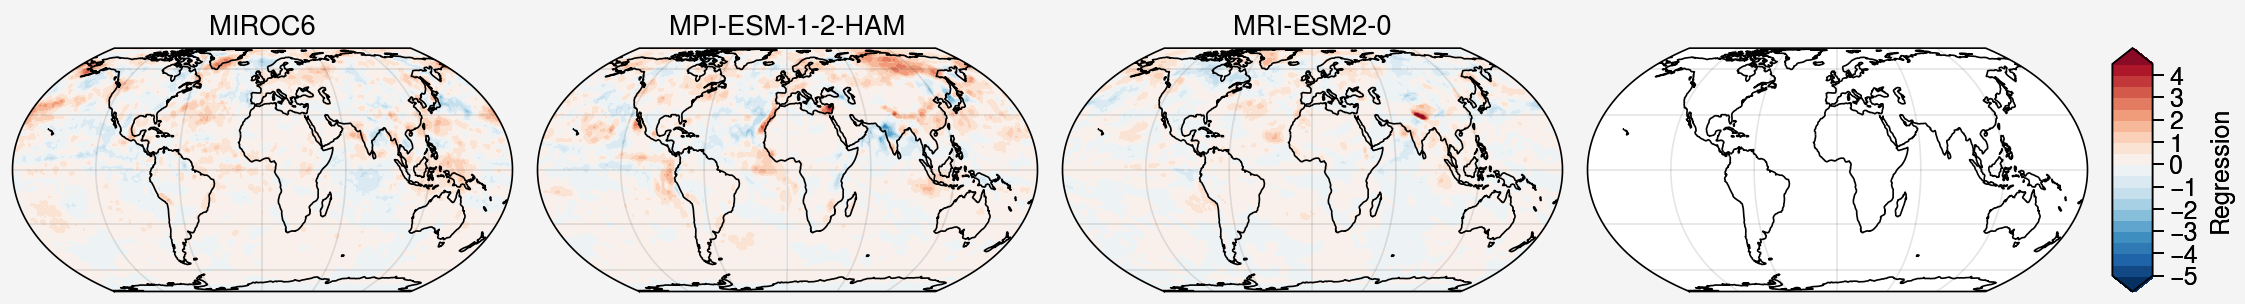

In [5]:
#CMIP6 models with different time format acres july regression
#Do now for models
download_path='/home/jupyter-dipti/work/data/data/'
inputstr='.historical.r1i1p1f1.Input.netSurfcs.nc'
outputstr='.historical.r1i1p1f1.Output.nc'

fig,axes = pplt.subplots([[1,2,3,4]],proj='eqearth')
for i,name in enumerate(othermodels):
    #get input variables in xarray
    files=download_path+name+inputstr
    data=xr.open_dataset(files)        
    lons=data['lon']
    lats=data['lat']
    cres=data['cres']
    cresSurf=data['cresSurf']
    
    acres=cres-cresSurf
    acres=acres[1548:,:,:]
    #acres['time']=datetimeindex
    
    #Done getting input variables, now get output variables - precipition
    files1=download_path+name+outputstr
    data1=xr.open_dataset(files1)
    prec=data1['pr']
    land=data1['lsMask']
    precip=xr.where(land==0,np.nan,prec) #remove oceans, monsoon is defined as only over land 
    precip=precip[1548:,:,:]
    #precip['time']=datetimeindex
    
    
    def detrend(x:np.ndarray,time:np.ndarray):
        nt,nx,ny = x.shape
        xtemp = x.reshape(nt,nx*ny)
        p = np.polyfit(time, xtemp, deg=3)
        fit = p[0]*(time[:,np.newaxis] **3)+ p[1]*(time[:,np.newaxis]**2) + p[2]*(time[:,np.newaxis]) + p[3]
        return x - fit.reshape(nt,nx,ny)
   

    #Do the weighted area correction:
    def earth_radius(lat):
        from numpy import deg2rad, sin, cos

        # define oblate spheroid from WGS84
        a = 6378137
        b = 6356752.3142
        e2 = 1 - (b**2/a**2)
    
    # convert from geodecic to geocentric
    # see equation 3-110 in WGS84
        lat = deg2rad(lat)
        lat_gc = np.arctan( (1-e2)*np.tan(lat) )
    
    # radius equation
    # see equation 3-107 in WGS84
        r = (
            (a * (1 - e2)**0.5) 
            / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
            )
    
        return r

    def area_grid(lat, lon):
    
        from numpy import meshgrid, deg2rad, gradient, cos
        from xarray import DataArray

        xlon, ylat = meshgrid(lon, lat)
        R = earth_radius(ylat)
    
    
        dlat = deg2rad(gradient(ylat, axis=0))
        dlon = deg2rad(gradient(xlon, axis=1))
    
        dy = dlat * R
        dx = dlon * R * cos(deg2rad(ylat))
    
        area = dy * dx
    
        xda = DataArray(
            area,
            dims=["lat", "lon"],
            coords={"lat": lat, "lon": lon},
            attrs={
                "long_name": "area_per_pixel",
            "description": "area per pixel",
            "units": "m^2",
            },
        )
        return xda
    
    
    da_area = area_grid(data['lat'], data['lon'])
    total_area=da_area.sum(['lat','lon'])

    
    #Select July index
    month_idxs=acres.groupby('time.month').groups
    july_idxs=month_idxs[7]
    test_idxs=month_idxs[7]
    acres_july=acres.isel(time=test_idxs)
    prec_july=precip.isel(time=july_idxs)
    
    testtime=prec_july.time
    
    SAMlat=acres_july.lat
    SAMlon=acres_july.lon

    #Detrend data sets
    time=acres_july.time
    acres_july=acres_july.to_numpy()
    time=time.to_numpy()
    prec_july=prec_july.to_numpy()

    time=time.astype(int)/10**9
    
    acres_july=detrend(acres_july,time)
    acres_july=xr.DataArray(acres_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])
    
    prec_july=detrend(prec_july,time)
    prec_july=xr.DataArray(prec_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_july=xr.where(prec_july<0,0,prec_july) #apply Non-negative precipitation physical constraint
    
    #Select only the SAM lat,lon range: 60-100E, 10-30N 
    prec_july=prec_july.sel(lon=slice(60,100))
    prec_july=prec_july.sel(lat=slice(10,30))
    
    
    #Do weighted correction on precipitation
    prec_weighted=(prec_july*da_area)/total_area #Do the weighted area correction
    prec_weighted_mean=prec_weighted.sum(['lat','lon']) #Sum across lat lon to get the mean weighted value
    prec_index=prec_weighted_mean*60*60*24 #conversion to mm/day, exluding dividing by rho and multiplying by 1000mm/m 

    mystd=prec_index.std()
    twostd=mystd*2
    mymean=prec_index.mean()
    condition=twostd+mymean

    pr_new,acres_july = xr.broadcast(prec_index,acres_july) #broadcast pr_mean array to fill array to allow regression to be executed

    #Calculate variable correlations
    corr=xr.corr(pr_new,acres_july,dim='time')
    fill=xr.zeros_like(corr) #Make array to be filled 
    fillarr=fill+1 #Make array full of ones

    corr1=xr.where(corr>0.3,fillarr,0) #Threshold value, above set to 1. Else=0 
    corr2=xr.where(corr<-0.3,fillarr,0) #Threshold value, below set to 1. Else=0

    #define the regression function
    def linear_trend(x,y): 
        mask=np.isfinite(x)&np.isfinite(y)
        if len(x[mask])==0:
            return np.nan
        else:
            pf=np.polyfit(x[mask],y[mask],1)
            return xr.DataArray(pf[0])

    def ints(x,y):
        mask=np.isfinite(x)&np.isfinite(y)
        if len(x[mask])==0:
            return np.nan
        else:
            ipf=np.polyfit(x[mask],y[mask],1)
            return xr.DataArray(ipf[1])


    #Apply regression function using ufunc to get regression coefficients/slopes
    slopes=xr.apply_ufunc(linear_trend,
                        pr_new,acres_july,
                        vectorize=True,
                        dask='parallelized',
                        input_core_dims=[['time'],['time']],
                        )



    intercepts=xr.apply_ufunc(ints,
                        pr_new,acres_july,
                        vectorize=True,
                        dask='parallelized',
                        input_core_dims=[['time'],['time']],
                        )


    regression=slopes*condition+intercepts
    
    
    con=axes[i].contourf(lons,lats,regression,levels=np.arange(-5,5,0.5),extend='both')
    #corrs1=axes.contour(lons,lats,corr1,colors='black',linewidths=0.05,levels=1) #Contour 0.3 threshold correlation
    #corrs2=axes.contour(lons,lats,corr2,colors='black',linewidths=0.05,levels=1) #Contour 0.3 threshold correlation
    axes[i].set_title(name)
fig.format(coast=True)
cbar=plt.colorbar(con)
cbar.set_label('Regression')
fig.save('OTHER_SAMonsoon_July-July_acres_Regression')

In [ ]:
#CMIP6 models with different time format cres july regression
#Do now for models
download_path='/home/jupyter-dipti/work/data/data/'
inputstr='.historical.r1i1p1f1.Input.netSurfcs.nc'
outputstr='.historical.r1i1p1f1.Output.nc'

fig,axes = pplt.subplots([[1,2,3,4]],proj='eqearth')
for i,name in enumerate(othermodels):
    #get input variables in xarray
    files=download_path+name+inputstr
    data=xr.open_dataset(files)        
    lons=data['lon']
    lats=data['lat']
    cres=data['cres']
    cresSurf=data['cresSurf']
    
    cres=cres-cresSurf
    cres=cres[1548:,:,:]
    #cres['time']=datetimeindex
    
    #Done getting input variables, now get output variables - precipition
    files1=download_path+name+outputstr
    data1=xr.open_dataset(files1)
    prec=data1['pr']
    land=data1['lsMask']
    precip=xr.where(land==0,np.nan,prec) #remove oceans, monsoon is defined as only over land 
    precip=precip[1548:,:,:]
    #precip['time']=datetimeindex
    
    
    def detrend(x:np.ndarray,time:np.ndarray):
        nt,nx,ny = x.shape
        xtemp = x.reshape(nt,nx*ny)
        p = np.polyfit(time, xtemp, deg=3)
        fit = p[0]*(time[:,np.newaxis] **3)+ p[1]*(time[:,np.newaxis]**2) + p[2]*(time[:,np.newaxis]) + p[3]
        return x - fit.reshape(nt,nx,ny)
   

    #Do the weighted area correction:
    def earth_radius(lat):
        from numpy import deg2rad, sin, cos

        # define oblate spheroid from WGS84
        a = 6378137
        b = 6356752.3142
        e2 = 1 - (b**2/a**2)
    
    # convert from geodecic to geocentric
    # see equation 3-110 in WGS84
        lat = deg2rad(lat)
        lat_gc = np.arctan( (1-e2)*np.tan(lat) )
    
    # radius equation
    # see equation 3-107 in WGS84
        r = (
            (a * (1 - e2)**0.5) 
            / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
            )
    
        return r

    def area_grid(lat, lon):
    
        from numpy import meshgrid, deg2rad, gradient, cos
        from xarray import DataArray

        xlon, ylat = meshgrid(lon, lat)
        R = earth_radius(ylat)
    
    
        dlat = deg2rad(gradient(ylat, axis=0))
        dlon = deg2rad(gradient(xlon, axis=1))
    
        dy = dlat * R
        dx = dlon * R * cos(deg2rad(ylat))
    
        area = dy * dx
    
        xda = DataArray(
            area,
            dims=["lat", "lon"],
            coords={"lat": lat, "lon": lon},
            attrs={
                "long_name": "area_per_pixel",
            "description": "area per pixel",
            "units": "m^2",
            },
        )
        return xda
    
    
    da_area = area_grid(data['lat'], data['lon'])
    total_area=da_area.sum(['lat','lon'])

    
    #Select July index
    month_idxs=cres.groupby('time.month').groups
    july_idxs=month_idxs[7]
    test_idxs=month_idxs[7]
    cres_july=cres.isel(time=test_idxs)
    prec_july=precip.isel(time=july_idxs)
    
    testtime=prec_july.time
    
    SAMlat=cres_july.lat
    SAMlon=cres_july.lon

    #Detrend data sets
    time=cres_july.time
    cres_july=cres_july.to_numpy()
    time=time.to_numpy()
    prec_july=prec_july.to_numpy()

    time=time.astype(int)/10**9
    
    cres_july=detrend(cres_july,time)
    cres_july=xr.DataArray(cres_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])
    
    prec_july=detrend(prec_july,time)
    prec_july=xr.DataArray(prec_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_july=xr.where(prec_july<0,0,prec_july) #apply Non-negative precipitation physical constraint
    
    #Select only the SAM lat,lon range: 60-100E, 10-30N 
    prec_july=prec_july.sel(lon=slice(60,100))
    prec_july=prec_july.sel(lat=slice(10,30))
    
    
    #Do weighted correction on precipitation
    prec_weighted=(prec_july*da_area)/total_area #Do the weighted area correction
    prec_weighted_mean=prec_weighted.sum(['lat','lon']) #Sum across lat lon to get the mean weighted value
    prec_index=prec_weighted_mean*60*60*24 #conversion to mm/day, exluding dividing by rho and multiplying by 1000mm/m 

    mystd=prec_index.std()
    twostd=mystd*2
    mymean=prec_index.mean()
    condition=twostd+mymean

    pr_new,cres_july = xr.broadcast(prec_index,cres_july) #broadcast pr_mean array to fill array to allow regression to be executed

    #Calculate variable correlations
    corr=xr.corr(pr_new,cres_july,dim='time')
    fill=xr.zeros_like(corr) #Make array to be filled 
    fillarr=fill+1 #Make array full of ones

    corr1=xr.where(corr>0.3,fillarr,0) #Threshold value, above set to 1. Else=0 
    corr2=xr.where(corr<-0.3,fillarr,0) #Threshold value, below set to 1. Else=0

    #define the regression function
    def linear_trend(x,y): 
        mask=np.isfinite(x)&np.isfinite(y)
        if len(x[mask])==0:
            return np.nan
        else:
            pf=np.polyfit(x[mask],y[mask],1)
            return xr.DataArray(pf[0])

    def ints(x,y):
        mask=np.isfinite(x)&np.isfinite(y)
        if len(x[mask])==0:
            return np.nan
        else:
            ipf=np.polyfit(x[mask],y[mask],1)
            return xr.DataArray(ipf[1])


    #Apply regression function using ufunc to get regression coefficients/slopes
    slopes=xr.apply_ufunc(linear_trend,
                        pr_new,cres_july,
                        vectorize=True,
                        dask='parallelized',
                        input_core_dims=[['time'],['time']],
                        )



    intercepts=xr.apply_ufunc(ints,
                        pr_new,cres_july,
                        vectorize=True,
                        dask='parallelized',
                        input_core_dims=[['time'],['time']],
                        )


    regression=slopes*condition+intercepts
    
    
    con=axes[i].contourf(lons,lats,regression,levels=np.arange(-5,5,0.5),extend='both')
    #corrs1=axes.contour(lons,lats,corr1,colors='black',linewidths=0.05,levels=1) #Contour 0.3 threshold correlation
    #corrs2=axes.contour(lons,lats,corr2,colors='black',linewidths=0.05,levels=1) #Contour 0.3 threshold correlation
    axes[i].set_title(name)
fig.format(coast=True)
cbar=plt.colorbar(con)
cbar.set_label('Regression')
fig.save('OTHER_SAMonsoon_July-July_cres_Regression')

In [6]:
#Loading in data for CESM2 ensemble
# Connect to AWS S3 storage
fs = s3fs.S3FileSystem(anon=True)
## By downloading the master CSV file enumerating all available data stores, we can interact with the spreadsheet
## through a pandas DataFrame to search and explore for relevant data using the CMIP6 controlled vocabulary:
df = pd.read_csv("https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.csv")

In [7]:
def getData(qstring):
    df_subset = df.query(qstring)
    if df_subset.empty:
        print('data not available for '+qstring)
    else:
        for v in df_subset.zstore.values:
            zstore = v
            mapper = fs.get_mapper(zstore)
            return_ds = xr.open_zarr(mapper, consolidated=True)
    return(return_ds)

In [8]:
modelName="'CESM2'"
institute="'NCAR'"
expList=["'historical'"]
actList=["'CMIP'"]
membList=["'r1i1p1f1'", "'r2i1p1f1'", "'r3i1p1f1'", "'r4i1p1f1'" , "'r5i1p1f1'", "'r6i1p1f1'", "'r7i1p1f1'","'r8i1p1f1'","'r9i1p1f1'","'r10i1p1f1'","'r11i1p1f1'"]

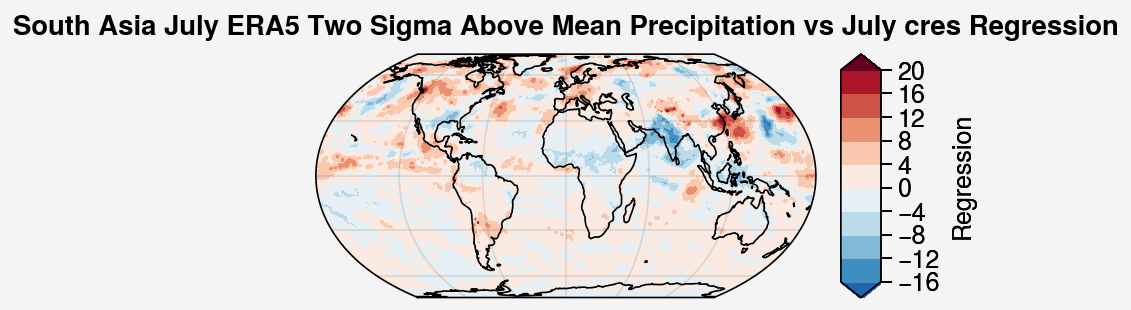

In [9]:
#ERA5 cres regression for July
#Run first the scripts for the ERA5 data
#get input variables in xarray
files='/home/jupyter-dipti/work/ERA5/ERA5_Exp8_Input.nc'
data=xr.open_dataset(files)   
lons=data['lon']
lats=data['lat']
land=data['lsMask']
cres=data['cres']


#Done getting input variables, now get output variables i.e precipition
files1='/home/jupyter-dipti/work/ERA5/ERA5_Exp8_Output.nc'
data1=xr.open_dataset(files1)
prec=data1['pr']

prec=xr.where(land==0,np.nan,prec) #remove oceans, monsoon is defined as only over land 

#Define detrend function to apply to data
def detrend(x:np.ndarray,time:np.ndarray):
        nt,nx,ny = x.shape
        xtemp = x.reshape(nt,nx*ny)
        p = np.polyfit(time, xtemp, deg=3)
        fit = p[0]*(time[:,np.newaxis] **3)+ p[1]*(time[:,np.newaxis]**2) + p[2]*(time[:,np.newaxis]) + p[3]
        return x - fit.reshape(nt,nx,ny)

    #Do the weighted area correction:
def earth_radius(lat):
    from numpy import deg2rad, sin, cos

    # define oblate spheroid from WGS84
    a = 6378137
    b = 6356752.3142
    e2 = 1 - (b**2/a**2)
    
    # convert from geodecic to geocentric
    lat = deg2rad(lat)
    lat_gc = np.arctan( (1-e2)*np.tan(lat) )
    
    # radius equation
    r = (
        (a * (1 - e2)**0.5) 
        / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
        )
    
    return r

def area_grid(lat, lon):
    from numpy import meshgrid, deg2rad, gradient, cos
    from xarray import DataArray

    xlon, ylat = meshgrid(lon, lat)
    R = earth_radius(ylat)
    
    
    dlat = deg2rad(gradient(ylat, axis=0))
    dlon = deg2rad(gradient(xlon, axis=1))
    
    dy = dlat * R
    dx = dlon * R * cos(deg2rad(ylat))
    
    
    area = dy * dx
    
    xda = DataArray(
        area,
        dims=["lat", "lon"],
        coords={"lat": lat, "lon": lon},
        attrs={
            "long_name": "area_per_pixel",
        "description": "area per pixel",
        "units": "m^2",
        },
    )
    return xda

da_area = area_grid(data['lat'], data['lon'])
total_area=da_area.sum(['lat','lon'])

#Align times with CMIP time by only looking at 1979-2014
cres=cres[:432,:,:]
precip=prec[:432,:,:]

#Select July index
month_idxs=cres.groupby('time.month').groups
july_idxs=month_idxs[7]
test_idxs=month_idxs[7]
cres_july=cres.isel(time=test_idxs)
prec_july=precip.isel(time=july_idxs)

SAMlat=cres_july.lat
SAMlon=cres_july.lon

#Detrend data sets
time=cres_july.time
cres_july=cres_july.to_numpy()
time=time.to_numpy()
prec_july=prec_july.to_numpy()

time=time.astype(int)/10**9

cres_july=detrend(cres_july,time)
cres_july=xr.DataArray(cres_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

prec_july=detrend(prec_july,time)
prec_july=xr.DataArray(prec_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

prec_july=xr.where(prec_july<0,0,prec_july) #apply Non-negative precipitation physical constraint

#Select only the SAM lat,lon range: 60-100E, 10-30N for precipitation
prec_july=prec_july.sel(lon=slice(60,100))
prec_july=prec_july[:,240:321,:]

#Do weighted correction on precipitation
prec_weighted=(prec_july*da_area)/total_area #Do the weighted area correction
prec_weighted_mean=prec_weighted.sum(['lat','lon']) #Sum across lat lon to get the mean weighted value
prec_index=prec_weighted_mean*60*60*24 #conversion to mm/yr, exluding dividing by rho and multiplying by 1000mm/m 

mystd=prec_index.std()
twostd=mystd*2
mymean=prec_index.mean()
condition=twostd+mymean

pr_new,cres_july = xr.broadcast(prec_index,cres_july) #broadcast pr_mean array to fill array to allow regression to be executed


#Calculate variable correlations
corr=xr.corr(pr_new,cres_july,dim='time')
fill=xr.zeros_like(corr) #Make array to be filled 
fillarr=fill+1 #Make array full of ones

corr1=xr.where(corr>0.3,fillarr,0) #Threshold value, above set to 1. Else=0 
corr2=xr.where(corr<-0.3,fillarr,0) #Threshold value, below set to 1. Else=0

#define the regression function
def linear_trend(x,y): 
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        pf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(pf[0])

def ints(x,y):
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        ipf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(ipf[1])



#Apply regression function using ufunc to get regression coefficients/slopes
slopes=xr.apply_ufunc(linear_trend,
                    pr_new,cres_july,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['time'],['time']],
                    )


intercepts=xr.apply_ufunc(ints,
                    pr_new,cres_july,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['time'],['time']],
                    )


regression=slopes*condition+intercepts

fig,axes=pplt.subplots([[1]],proj='eqearth')

con=axes.contourf(slopes.lon,slopes.lat,regression,extend='both')
#corrs1=axes.contour(lons,lats,corr1,colors='black',linewidths=0.05) #Contour 0.3 threshold correlation
#corrs2=axes.contour(lons,lats,corr2,colors='black',linewidths=0.05) #Contour 0.3 threshold correlation

fig.format(coast=True)
cbar=plt.colorbar(con)
axes.format(suptitle='South Asia July ERA5 Two Sigma Above Mean Precipitation vs July cres Regression')
cbar.set_label('Regression')
fig.save('ERA5_SAMonsoon_cres_July-July_Regression')

In [ ]:
#July
fig,axes = pplt.subplots([[1,2,3],[4,5,6],[7,8,9],[10,11,12]],proj='eqearth')
for i,memb in enumerate(membList):
        inputStr  = "institution_id =='NCAR' & source_id=='CESM2' & table_id=='Amon' & experiment_id=='historical' &  member_id=="+memb+" & variable_id=="
        rsut_ds=getData(inputStr+"'rsut'")
        rsdt_ds=getData(inputStr+"'rsdt'")
        rsutcs_ds=getData(inputStr+"'rsutcs'")
        
        lats=rsut_ds['lat']
        lons=rsut_ds['lon']
        
        rsut=rsut_ds['rsut']
        rsutcs=rsutcs_ds['rsutcs']
        pr_ds=getData(inputStr+"'pr'")
        
        cres=rsutcs-rsut
        precip=pr_ds['pr']
        cres=cres[1548:,:,:]
        precip=precip[1548:,:,:]
        
        datetimeindex=cres.indexes['time'].to_datetimeindex()
        cres['time']=datetimeindex
        precip['time']=datetimeindex
        
    
        def detrend(x:np.ndarray,time:np.ndarray):
            nt,nx,ny = x.shape
            xtemp = x.reshape(nt,nx*ny)
            p = np.polyfit(time, xtemp, deg=3)
            fit = p[0]*(time[:,np.newaxis] **3)+ p[1]*(time[:,np.newaxis]**2) + p[2]*(time[:,np.newaxis]) + p[3]
            return x - fit.reshape(nt,nx,ny)
   

        #Do the weighted area correction:
        def earth_radius(lat):
            from numpy import deg2rad, sin, cos

            # define oblate spheroid from WGS84
            a = 6378137
            b = 6356752.3142
            e2 = 1 - (b**2/a**2)
    
        # convert from geodecic to geocentric
        # see equation 3-110 in WGS84
            lat = deg2rad(lat)
            lat_gc = np.arctan( (1-e2)*np.tan(lat) )
    
        # radius equation
        # see equation 3-107 in WGS84
            r = (
                (a * (1 - e2)**0.5) 
                / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
                )
            
            return r

        def area_grid(lat, lon):
    
            from numpy import meshgrid, deg2rad, gradient, cos
            from xarray import DataArray

            xlon, ylat = meshgrid(lon, lat)
            R = earth_radius(ylat)
    
    
            dlat = deg2rad(gradient(ylat, axis=0))
            dlon = deg2rad(gradient(xlon, axis=1))
    
            dy = dlat * R
            dx = dlon * R * cos(deg2rad(ylat))
    
            area = dy * dx
    
            xda = DataArray(
                area,
                dims=["lat", "lon"],
                coords={"lat": lat, "lon": lon},
                attrs={
                    "long_name": "area_per_pixel",
                "description": "area per pixel",
                "units": "m^2",
                },
            )
            return xda
    
    
        da_area = area_grid(rsut_ds['lat'], rsut_ds['lon'])
        total_area=da_area.sum(['lat','lon'])

        #Select July index
        month_idxs=cres.groupby('time.month').groups
        july_idxs=month_idxs[7]
        test_idxs=month_idxs[4]
        cres_july=cres.isel(time=test_idxs)
        prec_july=precip.isel(time=july_idxs)


        SAMlat=cres_july.lat
        SAMlon=cres_july.lon

        #Detrend data sets
        time=cres_july.time
        cres_july=cres_july.to_numpy()
        time=time.to_numpy()
        prec_july=prec_july.to_numpy()

        time=time.astype(int)/10**9

        cres_july=detrend(cres_july,time)
        cres_july=xr.DataArray(cres_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

        prec_july=detrend(prec_july,time)
        prec_july=xr.DataArray(prec_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

        prec_july=xr.where(prec_july<0,0,prec_july) #apply Non-negative precipitation physical constraint

        #Select only the SAM lat,lon range: 60-100E, 10-30N 
        prec_july=prec_july.sel(lon=slice(60,100))
        prec_july=prec_july.sel(lat=slice(10,30))


        #Do weighted correction on precipitation
        prec_weighted=(prec_july*da_area)/total_area #Do the weighted area correction
        prec_weighted_mean=prec_weighted.sum(['lat','lon']) #Sum across lat lon to get the mean weighted value
        prec_index=prec_weighted_mean*60*60*24*365.25 #conversion to mm/yr, exluding dividing by rho and multiplying by 1000mm/m 

        mystd=prec_index.std()
        twostd=mystd*2
        mymean=prec_index.mean()
        condition=twostd+mymean

        pr_new,cres_july = xr.broadcast(prec_index,cres_july) #broadcast pr_mean array to fill array to allow regression to be executed
        #Calculate variable correlations
        corr=xr.corr(pr_new,acres_july,dim='time')
        fill=xr.zeros_like(corr) #Make array to be filled 
        fillarr=fill+1 #Make array full of ones

        corr1=xr.where(corr>0.3,fillarr,0) #Threshold value, above set to 1. Else=0 
        corr2=xr.where(corr<-0.3,fillarr,0) #Threshold value, below set to 1. Else=0

        #define the regression function
        def linear_trend(x,y): 
            mask=np.isfinite(x)&np.isfinite(y)
            if len(x[mask])==0:
                return np.nan
            else:
                pf=np.polyfit(x[mask],y[mask],1)
                return xr.DataArray(pf[0])

        def ints(x,y):
            mask=np.isfinite(x)&np.isfinite(y)
            if len(x[mask])==0:
                return np.nan
            else:
                ipf=np.polyfit(x[mask],y[mask],1)
                return xr.DataArray(ipf[1])


        #Apply regression function using ufunc to get regression coefficients/slopes
        slopes=xr.apply_ufunc(linear_trend,
                            pr_new,cres_july,
                            vectorize=True,
                            dask='parallelized',
                            input_core_dims=[['time'],['time']],
                            )



        intercepts=xr.apply_ufunc(ints,
                            pr_new,cres_july,
                            vectorize=True,
                            dask='parallelized',
                            input_core_dims=[['time'],['time']],
                            )


        regression=slopes*condition+intercepts

        con=axes[i].contourf(lons,lats,regression,extend='both')
        #corrs1=axes.contour(lons,lats,corr1,colors='black',linewidths=0.05) #Contour 0.3 threshold correlation
        #corrs2=axes.contour(lons,lats,corr2,colors='black',linewidths=0.05) #Contour 0.3 threshold correlation
        axes[i].set_title(memb)
fig.format(coast=True)
cbar=plt.colorbar(con)
cbar.set_label('Regression')
axes.format(suptitle='CESM Ensemble South Asia July Two Sigma Above Mean Precipitation vs July cres Regression')
fig.save('CESM2Ensemble_SAMonsoon_July-July_cres_Regression')

In [ ]:
#Now for July precip - April acres

In [ ]:
#ERA5 acres regression
#Run first the scripts for the ERA5 data
#get input variables in xarray
files='/home/jupyter-dipti/work/ERA5/ERA5_Exp8_Input.nc'
data=xr.open_dataset(files)   
lons=data['lon']
lats=data['lat']
land=data['lsMask']
cres=data['cres']
cresSurf=data['cresSurf']

acres=cres-cresSurf

#Done getting input variables, now get output variables i.e precipition
files1='/home/jupyter-dipti/work/ERA5/ERA5_Exp8_Output.nc'
data1=xr.open_dataset(files1)
prec=data1['pr']

prec=xr.where(land==0,np.nan,prec) #remove oceans, monsoon is defined as only over land 

#Define detrend function to apply to data
def detrend(x:np.ndarray,time:np.ndarray):
        nt,nx,ny = x.shape
        xtemp = x.reshape(nt,nx*ny)
        p = np.polyfit(time, xtemp, deg=3)
        fit = p[0]*(time[:,np.newaxis] **3)+ p[1]*(time[:,np.newaxis]**2) + p[2]*(time[:,np.newaxis]) + p[3]
        return x - fit.reshape(nt,nx,ny)

    #Do the weighted area correction:
def earth_radius(lat):
    from numpy import deg2rad, sin, cos

    # define oblate spheroid from WGS84
    a = 6378137
    b = 6356752.3142
    e2 = 1 - (b**2/a**2)
    
    # convert from geodecic to geocentric
    lat = deg2rad(lat)
    lat_gc = np.arctan( (1-e2)*np.tan(lat) )
    
    # radius equation
    r = (
        (a * (1 - e2)**0.5) 
        / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
        )
    
    return r

def area_grid(lat, lon):
    from numpy import meshgrid, deg2rad, gradient, cos
    from xarray import DataArray

    xlon, ylat = meshgrid(lon, lat)
    R = earth_radius(ylat)
    
    
    dlat = deg2rad(gradient(ylat, axis=0))
    dlon = deg2rad(gradient(xlon, axis=1))
    
    dy = dlat * R
    dx = dlon * R * cos(deg2rad(ylat))
    
    
    area = dy * dx
    
    xda = DataArray(
        area,
        dims=["lat", "lon"],
        coords={"lat": lat, "lon": lon},
        attrs={
            "long_name": "area_per_pixel",
        "description": "area per pixel",
        "units": "m^2",
        },
    )
    return xda

da_area = area_grid(data['lat'], data['lon'])
total_area=da_area.sum(['lat','lon'])

#Align times with CMIP time by only looking at 1979-2014
acres=acres[:432,:,:]
precip=prec[:432,:,:]

#Select July index
month_idxs=acres.groupby('time.month').groups
july_idxs=month_idxs[7]
test_idxs=month_idxs[4]
acres_july=acres.isel(time=test_idxs)
prec_july=precip.isel(time=july_idxs)

SAMlat=acres_july.lat
SAMlon=acres_july.lon

#Detrend data sets
time=acres_july.time
acres_july=acres_july.to_numpy()
time=time.to_numpy()
prec_july=prec_july.to_numpy()

time=time.astype(int)/10**9

acres_july=detrend(acres_july,time)
acres_july=xr.DataArray(acres_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

prec_july=detrend(prec_july,time)
prec_july=xr.DataArray(prec_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

prec_july=xr.where(prec_july<0,0,prec_july) #apply Non-negative precipitation physical constraint

#Select only the SAM lat,lon range: 60-100E, 10-30N for precipitation
prec_july=prec_july.sel(lon=slice(60,100))
prec_july=prec_july[:,240:321,:]

#Do weighted correction on precipitation
prec_weighted=(prec_july*da_area)/total_area #Do the weighted area correction
prec_weighted_mean=prec_weighted.sum(['lat','lon']) #Sum across lat lon to get the mean weighted value
prec_index=prec_weighted_mean*60*60*24 #conversion to mm/yr, exluding dividing by rho and multiplying by 1000mm/m 

mystd=prec_index.std()
twostd=mystd*2
mymean=prec_index.mean()
condition=twostd+mymean

pr_new,acres_july = xr.broadcast(prec_index,acres_july) #broadcast pr_mean array to fill array to allow regression to be executed

#Calculate variable correlations
corr=xr.corr(pr_new,acres_july,dim='time')
fill=xr.zeros_like(corr) #Make array to be filled 
fillarr=fill+1 #Make array full of ones

corr1=xr.where(corr>0.3,fillarr,0) #Threshold value, above set to 1. Else=0 
corr2=xr.where(corr<-0.3,fillarr,0) #Threshold value, below set to 1. Else=0

#define the regression function
def linear_trend(x,y): 
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        pf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(pf[0])

def ints(x,y):
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        ipf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(ipf[1])



#Apply regression function using ufunc to get regression coefficients/slopes
slopes=xr.apply_ufunc(linear_trend,
                    pr_new,acres_july,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['time'],['time']],
                    )


intercepts=xr.apply_ufunc(ints,
                    pr_new,acres_july,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['time'],['time']],
                    )


regression=slopes*condition+intercepts

fig,axes=pplt.subplots([[1]],proj='eqearth')

con=axes.contourf(slopes.lon,slopes.lat,regression,levels=np.arange(-1,1,0.1)extend='both')
#corrs1=axes.contour(lons,lats,corr1,colors='black',linewidths=0.05,levels=2) #Contour 0.3 threshold correlation
#corrs2=axes.contour(lons,lats,corr2,colors='black',linewidths=0.05,levels=2) #Contour 0.3 threshold correlation

fig.format(coast=True)
cbar=plt.colorbar(con)
axes.format(suptitle='South Asia July ERA5 Two Sigma Above Mean Precipitation vs April acres Regression')
cbar.set_label('Regression')
#fig.save('ERA5_SAMonsoon_acres_July-April_Regression')

In [ ]:
#CMIP6 acres regression
#Do now for models
download_path='/home/jupyter-dipti/work/data/data/'
inputstr='.historical.r1i1p1f1.Input.netSurfcs.nc'
outputstr='.historical.r1i1p1f1.Output.nc'

fig,axes = pplt.subplots([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]],proj='eqearth')
for i,name in enumerate(modelNames):
    #get input variables in xarray
    files=download_path+name+inputstr
    data=xr.open_dataset(files)        
    lons=data['lon']
    lats=data['lat']
    land=data['lsMask']
    cres=data['cres']
    cresSurf=data['cresSurf']

    acres=cres-cresSurf
    
    acres=acres[1548:,:,:]
    datetimeindex=acres.indexes['time'].to_datetimeindex()
    acres['time']=datetimeindex
    
    #Done getting input variables, now get output variables - precipition
    files1=download_path+name+outputstr
    data1=xr.open_dataset(files1)
    prec=data1['pr']
    land=data1['lsMask']
    precip=xr.where(land==0,np.nan,prec) #remove oceans, monsoon is defined as only over land 
    precip=precip[1548:,:,:]
    precip['time']=datetimeindex
    
    
    def detrend(x:np.ndarray,time:np.ndarray):
        nt,nx,ny = x.shape
        xtemp = x.reshape(nt,nx*ny)
        p = np.polyfit(time, xtemp, deg=3)
        fit = p[0]*(time[:,np.newaxis] **3)+ p[1]*(time[:,np.newaxis]**2) + p[2]*(time[:,np.newaxis]) + p[3]
        return x - fit.reshape(nt,nx,ny)
   

    #Do the weighted area correction:
    def earth_radius(lat):
        from numpy import deg2rad, sin, cos

        # define oblate spheroid from WGS84
        a = 6378137
        b = 6356752.3142
        e2 = 1 - (b**2/a**2)
    
    # convert from geodecic to geocentric
    # see equation 3-110 in WGS84
        lat = deg2rad(lat)
        lat_gc = np.arctan( (1-e2)*np.tan(lat) )
    
    # radius equation
    # see equation 3-107 in WGS84
        r = (
            (a * (1 - e2)**0.5) 
            / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
            )
    
        return r

    def area_grid(lat, lon):
    
        from numpy import meshgrid, deg2rad, gradient, cos
        from xarray import DataArray

        xlon, ylat = meshgrid(lon, lat)
        R = earth_radius(ylat)
    
    
        dlat = deg2rad(gradient(ylat, axis=0))
        dlon = deg2rad(gradient(xlon, axis=1))
    
        dy = dlat * R
        dx = dlon * R * cos(deg2rad(ylat))
    
        area = dy * dx
    
        xda = DataArray(
            area,
            dims=["lat", "lon"],
            coords={"lat": lat, "lon": lon},
            attrs={
                "long_name": "area_per_pixel",
            "description": "area per pixel",
            "units": "m^2",
            },
        )
        return xda
    
    
    da_area = area_grid(data['lat'], data['lon'])
    total_area=da_area.sum(['lat','lon'])

    
    #Select July index
    month_idxs=acres.groupby('time.month').groups
    july_idxs=month_idxs[7]
    test_idxs=month_idxs[4]
    acres_july=acres.isel(time=test_idxs)
    prec_july=precip.isel(time=july_idxs)
    
    testtime=prec_july.time

    SAMlat=acres_july.lat
    SAMlon=acres_july.lon

    #Detrend data sets
    time=acres_july.time
    acres_july=acres_july.to_numpy()
    time=time.to_numpy()
    prec_july=prec_july.to_numpy()

    time=time.astype(int)/10**9

    acres_july=detrend(acres_july,time)
    acres_july=xr.DataArray(acres_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_july=detrend(prec_july,time)
    prec_july=xr.DataArray(prec_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_july=xr.where(prec_july<0,0,prec_july) #apply Non-negative precipitation physical constraint

    #Select only the SAM lat,lon range: 60-100E, 10-30N 
    prec_july=prec_july.sel(lon=slice(60,100))
    prec_july=prec_july.sel(lat=slice(10,30))

    #Do weighted correction on precipitation
    prec_weighted=(prec_july*da_area)/total_area #Do the weighted area correction
    prec_weighted_mean=prec_weighted.sum(['lat','lon']) #Sum across lat lon to get the mean weighted value
    prec_index=prec_weighted_mean*60*60*24 #conversion to mm/day, exluding dividing by rho and multiplying by 1000mm/m 

    mystd=prec_index.std()
    twostd=mystd*2
    mymean=prec_index.mean()
    condition=twostd+mymean

    pr_new,acres_july = xr.broadcast(prec_index,acres_july) #broadcast pr_mean array to fill array to allow regression to be executed
    
    #Calculate variable correlations
    corr=xr.corr(pr_new,acres_july,dim='time')
    fill=xr.zeros_like(corr) #Make array to be filled 
    fillarr=fill+1 #Make array full of ones

    corr1=xr.where(corr>0.3,fillarr,0) #Threshold value, above set to 1. Else=0 
    corr2=xr.where(corr<-0.3,fillarr,0) #Threshold value, below set to 1. Else=0
    
    #define the regression function
    def linear_trend(x,y): 
        mask=np.isfinite(x)&np.isfinite(y)
        if len(x[mask])==0:
            return np.nan
        else:
            pf=np.polyfit(x[mask],y[mask],1)
            return xr.DataArray(pf[0])

    def ints(x,y):
        mask=np.isfinite(x)&np.isfinite(y)
        if len(x[mask])==0:
            return np.nan
        else:
            ipf=np.polyfit(x[mask],y[mask],1)
            return xr.DataArray(ipf[1])


    #Apply regression function using ufunc to get regression coefficients/slopes
    slopes=xr.apply_ufunc(linear_trend,
                        pr_new,acres_july,
                        vectorize=True,
                        dask='parallelized',
                        input_core_dims=[['time'],['time']],
                        )



    intercepts=xr.apply_ufunc(ints,
                        pr_new,acres_july,
                        vectorize=True,
                        dask='parallelized',
                        input_core_dims=[['time'],['time']],
                        )


    regression=slopes*condition+intercepts
    
    
    con=axes[i].contourf(lons,lats,regression,levels=np.arange(-2,2,0.2),extend='both')
    #corrs1=axes.contour(lons,lats,corr1,colors='black',linewidths=0.05,levels=1) #Contour 0.3 threshold correlation
    #corrs2=axes.contour(lons,lats,corr2,colors='black',linewidths=0.05,levels=1) #Contour 0.3 threshold correlation
    axes[i].set_title(name)
fig.format(coast=True)
cbar=plt.colorbar(con)
axes.format(suptitle='South Asia July Two Sigma Above Mean Precipitation vs April acres Regression')
cbar.set_label('Regression')
#fig.save('SAMonsoon_July-April_acres_Regression')

In [ ]:
#CMIP6 models with different time format acres july regression
#Do now for models
download_path='/home/jupyter-dipti/work/data/data/'
inputstr='.historical.r1i1p1f1.Input.netSurfcs.nc'
outputstr='.historical.r1i1p1f1.Output.nc'

fig,axes = pplt.subplots([[1,2,3,4]],proj='eqearth')
for i,name in enumerate(othermodels):
    #get input variables in xarray
    files=download_path+name+inputstr
    data=xr.open_dataset(files)        
    lons=data['lon']
    lats=data['lat']
    cres=data['cres']
    cresSurf=data['cresSurf']
    
    acres=cres-cresSurf
    acres=acres[1548:,:,:]
    #acres['time']=datetimeindex
    
    #Done getting input variables, now get output variables - precipition
    files1=download_path+name+outputstr
    data1=xr.open_dataset(files1)
    prec=data1['pr']
    land=data1['lsMask']
    precip=xr.where(land==0,np.nan,prec) #remove oceans, monsoon is defined as only over land 
    precip=precip[1548:,:,:]
    #precip['time']=datetimeindex
    
    
    def detrend(x:np.ndarray,time:np.ndarray):
        nt,nx,ny = x.shape
        xtemp = x.reshape(nt,nx*ny)
        p = np.polyfit(time, xtemp, deg=3)
        fit = p[0]*(time[:,np.newaxis] **3)+ p[1]*(time[:,np.newaxis]**2) + p[2]*(time[:,np.newaxis]) + p[3]
        return x - fit.reshape(nt,nx,ny)
   

    #Do the weighted area correction:
    def earth_radius(lat):
        from numpy import deg2rad, sin, cos

        # define oblate spheroid from WGS84
        a = 6378137
        b = 6356752.3142
        e2 = 1 - (b**2/a**2)
    
    # convert from geodecic to geocentric
    # see equation 3-110 in WGS84
        lat = deg2rad(lat)
        lat_gc = np.arctan( (1-e2)*np.tan(lat) )
    
    # radius equation
    # see equation 3-107 in WGS84
        r = (
            (a * (1 - e2)**0.5) 
            / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
            )
    
        return r

    def area_grid(lat, lon):
    
        from numpy import meshgrid, deg2rad, gradient, cos
        from xarray import DataArray

        xlon, ylat = meshgrid(lon, lat)
        R = earth_radius(ylat)
    
    
        dlat = deg2rad(gradient(ylat, axis=0))
        dlon = deg2rad(gradient(xlon, axis=1))
    
        dy = dlat * R
        dx = dlon * R * cos(deg2rad(ylat))
    
        area = dy * dx
    
        xda = DataArray(
            area,
            dims=["lat", "lon"],
            coords={"lat": lat, "lon": lon},
            attrs={
                "long_name": "area_per_pixel",
            "description": "area per pixel",
            "units": "m^2",
            },
        )
        return xda
    
    
    da_area = area_grid(data['lat'], data['lon'])
    total_area=da_area.sum(['lat','lon'])

    
    #Select July index
    month_idxs=acres.groupby('time.month').groups
    july_idxs=month_idxs[7]
    test_idxs=month_idxs[4]
    acres_july=acres.isel(time=test_idxs)
    prec_july=precip.isel(time=july_idxs)
    
    testtime=prec_july.time
    
    SAMlat=acres_july.lat
    SAMlon=acres_july.lon

    #Detrend data sets
    time=acres_july.time
    acres_july=acres_july.to_numpy()
    time=time.to_numpy()
    prec_july=prec_july.to_numpy()

    time=time.astype(int)/10**9
    
    acres_july=detrend(acres_july,time)
    acres_july=xr.DataArray(acres_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])
    
    prec_july=detrend(prec_july,time)
    prec_july=xr.DataArray(prec_july,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_july=xr.where(prec_july<0,0,prec_july) #apply Non-negative precipitation physical constraint
    
    #Select only the SAM lat,lon range: 60-100E, 10-30N 
    prec_july=prec_july.sel(lon=slice(60,100))
    prec_july=prec_july.sel(lat=slice(10,30))
    
    
    #Do weighted correction on precipitation
    prec_weighted=(prec_july*da_area)/total_area #Do the weighted area correction
    prec_weighted_mean=prec_weighted.sum(['lat','lon']) #Sum across lat lon to get the mean weighted value
    prec_index=prec_weighted_mean*60*60*24 #conversion to mm/day, exluding dividing by rho and multiplying by 1000mm/m 

    mystd=prec_index.std()
    twostd=mystd*2
    mymean=prec_index.mean()
    condition=twostd+mymean

    pr_new,acres_july = xr.broadcast(prec_index,acres_july) #broadcast pr_mean array to fill array to allow regression to be executed

    #Calculate variable correlations
    corr=xr.corr(pr_new,acres_july,dim='time')
    fill=xr.zeros_like(corr) #Make array to be filled 
    fillarr=fill+1 #Make array full of ones

    corr1=xr.where(corr>0.3,fillarr,0) #Threshold value, above set to 1. Else=0 
    corr2=xr.where(corr<-0.3,fillarr,0) #Threshold value, below set to 1. Else=0

    #define the regression function
    def linear_trend(x,y): 
        mask=np.isfinite(x)&np.isfinite(y)
        if len(x[mask])==0:
            return np.nan
        else:
            pf=np.polyfit(x[mask],y[mask],1)
            return xr.DataArray(pf[0])

    def ints(x,y):
        mask=np.isfinite(x)&np.isfinite(y)
        if len(x[mask])==0:
            return np.nan
        else:
            ipf=np.polyfit(x[mask],y[mask],1)
            return xr.DataArray(ipf[1])


    #Apply regression function using ufunc to get regression coefficients/slopes
    slopes=xr.apply_ufunc(linear_trend,
                        pr_new,acres_july,
                        vectorize=True,
                        dask='parallelized',
                        input_core_dims=[['time'],['time']],
                        )



    intercepts=xr.apply_ufunc(ints,
                        pr_new,acres_july,
                        vectorize=True,
                        dask='parallelized',
                        input_core_dims=[['time'],['time']],
                        )


    regression=slopes*condition+intercepts
    

    con=axes[i].contourf(lons,lats,regression,levels=np.arange(-2,2,0.2),extend='both')
    #corrs1=axes.contour(lons,lats,corr1,colors='black',linewidths=0.05,levels=1) #Contour 0.3 threshold correlation
    #corrs2=axes.contour(lons,lats,corr2,colors='black',linewidths=0.05,levels=1) #Contour 0.3 threshold correlation
    axes[i].set_title(name)
fig.format(coast=True)
cbar=plt.colorbar(con)
cbar.set_label('Regression')
#fig.save('OTHER_SAMonsoon_July-April_acres_Regression')